# VideoMAE Phase 3 - Complete Training + Evaluation

**Features:**
1. VideoMAE-Base (Kinetics-400 pretrained)
2. 2-Stage Training: Mixup → Label Smoothing
3. Test Set Evaluation with Ground Truth
4. Training Curves Plotting
5. History CSV Export

In [1]:
!uv pip install -q transformers accelerate evaluate

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor
from transformers import get_cosine_schedule_with_warmup
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
import os
import gc

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Paths
PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'

2026-01-19 16:52:01.406049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768841521.627537      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768841521.690878      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


## 1. Configuration

In [3]:
# Model Config
MODEL_CKPT = 'MCG-NJU/videomae-base-finetuned-kinetics'
NUM_FRAMES = 16
IMG_SIZE = 224
RESIZE_SIZE = 256

# Phase 1 Config (Mixup)
EPOCHS_P1 = 30
LR_P1 = 5e-5

# Phase 2 Config (Label Smoothing)
EPOCHS_P2 = 10
LR_P2 = 1e-6
LABEL_SMOOTHING = 0.1

# Common Config2
BATCH_SIZE = 20
ACCUM_STEPS = 4
WEIGHT_DECAY = 0.05
WARMUP_RATIO = 0.1

# Augmentation
MIXUP_ALPHA = 0.8
MIXUP_PROB = 1.0

# Normalization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## 1.5. Offline Data Augmentation

**Strategy**: Balance class distribution by generating 6 variations:
1. Original
2. Horizontal Flip
3. Rotate ±10°
4. Crop/Zoom (90%)
5. Flip + Brightness
6. Rotate + Crop

In [ ]:
import shutil
from collections import Counter

def get_class_distribution(train_path):
    """Count samples per class"""
    train_path = Path(train_path)
    class_counts = {}
    for cls_dir in train_path.iterdir():
        if cls_dir.is_dir():
            video_count = len([d for d in cls_dir.iterdir() if d.is_dir()])
            class_counts[cls_dir.name] = video_count
    return class_counts

def augment_video_frames(src_dir, dst_dir, transform_type):
    """Apply augmentation to all frames in a video directory"""
    dst_dir.mkdir(parents=True, exist_ok=True)
    
    for frame_path in sorted(src_dir.glob('*.jpg')):
        img = Image.open(frame_path)
        
        if transform_type == 'flip':
            img = TF.hflip(img)
        elif transform_type == 'rotate_neg':
            img = TF.rotate(img, -10, fill=0)
        elif transform_type == 'rotate_pos':
            img = TF.rotate(img, 10, fill=0)
        elif transform_type == 'crop':
            w, h = img.size
            crop_size = int(min(w, h) * 0.9)
            left = (w - crop_size) // 2
            top = (h - crop_size) // 2
            img = TF.crop(img, top, left, crop_size, crop_size)
            img = TF.resize(img, (h, w))
        elif transform_type == 'flip_bright':
            img = TF.hflip(img)
            img = TF.adjust_brightness(img, 1.2)
        elif transform_type == 'rotate_crop':
            img = TF.rotate(img, -8, fill=0)
            w, h = img.size
            crop_size = int(min(w, h) * 0.92)
            left = (w - crop_size) // 2
            top = (h - crop_size) // 2
            img = TF.crop(img, top, left, crop_size, crop_size)
            img = TF.resize(img, (h, w))
        
        img.save(dst_dir / frame_path.name, quality=95)

def balance_dataset(train_path, output_path, target_per_class=None):
    """Balance dataset by augmenting minority classes"""
    train_path = Path(train_path)
    output_path = Path(output_path)
    
    # Get current distribution
    class_counts = get_class_distribution(train_path)
    max_count = max(class_counts.values())
    target = target_per_class or max_count
    
    print(f'Target samples per class: {target}')
    print(f'Max class: {max_count}, Min class: {min(class_counts.values())}')
    
    # Augmentation types
    aug_types = ['flip', 'rotate_neg', 'rotate_pos', 'crop', 'flip_bright', 'rotate_crop']
    
    # Copy original + augment
    total_created = 0
    for cls_name, count in tqdm(class_counts.items(), desc='Balancing classes'):
        cls_src = train_path / cls_name
        cls_dst = output_path / cls_name
        cls_dst.mkdir(parents=True, exist_ok=True)
        
        videos = sorted([d for d in cls_src.iterdir() if d.is_dir()])
        
        # Copy originals
        for v in videos:
            dst = cls_dst / v.name
            if not dst.exists():
                shutil.copytree(v, dst)
        
        # Calculate how many augmented samples needed
        needed = target - count
        if needed <= 0:
            continue
        
        # Generate augmented samples
        aug_idx = 0
        created = 0
        while created < needed:
            for v in videos:
                if created >= needed:
                    break
                aug_type = aug_types[aug_idx % len(aug_types)]
                aug_name = f'{v.name}_aug_{aug_type}_{aug_idx // len(aug_types)}'
                dst = cls_dst / aug_name
                if not dst.exists():
                    augment_video_frames(v, dst, aug_type)
                    created += 1
                    total_created += 1
            aug_idx += 1
    
    print(f'\n✓ Created {total_created} augmented videos')
    return output_path

print('Augmentation functions defined')

In [ ]:
# Analyze BEFORE augmentation
print('=' * 60)
print('BEFORE AUGMENTATION')
print('=' * 60)

before_counts = get_class_distribution(PATH_DATA_TRAIN)
before_df = pd.DataFrame([
    {'class': k, 'count': v} for k, v in before_counts.items()
]).sort_values('count', ascending=False)

print(f'Total classes: {len(before_counts)}')
print(f'Total samples: {sum(before_counts.values())}')
print(f'Max: {max(before_counts.values())} ({max(before_counts, key=before_counts.get)})')
print(f'Min: {min(before_counts.values())} ({min(before_counts, key=before_counts.get)})')
print(f'Imbalance ratio: {max(before_counts.values()) / min(before_counts.values()):.2f}x')

# Plot
plt.figure(figsize=(16, 5))
plt.bar(range(len(before_df)), before_df['count'].values, color='steelblue', alpha=0.7)
plt.xlabel('Class (sorted by count)')
plt.ylabel('Number of samples')
plt.title('BEFORE Augmentation: Class Distribution')
plt.xticks(range(len(before_df)), before_df['class'].values, rotation=90, fontsize=7)
plt.tight_layout()
plt.savefig('distribution_before.png', dpi=150)
plt.show()

In [ ]:
# Run augmentation
PATH_DATA_AUGMENTED = '/kaggle/working/data_train_augmented'

# Balance to max class count
balanced_path = balance_dataset(PATH_DATA_TRAIN, PATH_DATA_AUGMENTED)

# Update train path for rest of notebook
PATH_DATA_TRAIN = str(balanced_path)
print(f'\n✓ Updated PATH_DATA_TRAIN to: {PATH_DATA_TRAIN}')

In [ ]:
# Analyze AFTER augmentation
print('=' * 60)
print('AFTER AUGMENTATION')
print('=' * 60)

after_counts = get_class_distribution(PATH_DATA_TRAIN)
after_df = pd.DataFrame([
    {'class': k, 'count': v} for k, v in after_counts.items()
]).sort_values('count', ascending=False)

print(f'Total classes: {len(after_counts)}')
print(f'Total samples: {sum(after_counts.values())}')
print(f'Max: {max(after_counts.values())} ({max(after_counts, key=after_counts.get)})')
print(f'Min: {min(after_counts.values())} ({min(after_counts, key=after_counts.get)})')
print(f'Imbalance ratio: {max(after_counts.values()) / min(after_counts.values()):.2f}x')

# Plot
plt.figure(figsize=(16, 5))
plt.bar(range(len(after_df)), after_df['count'].values, color='darkgreen', alpha=0.7)
plt.xlabel('Class (sorted by count)')
plt.ylabel('Number of samples')
plt.title('AFTER Augmentation: Class Distribution (Balanced)')
plt.xticks(range(len(after_df)), after_df['class'].values, rotation=90, fontsize=7)
plt.tight_layout()
plt.savefig('distribution_after.png', dpi=150)
plt.show()

# Summary comparison
print('\n' + '=' * 60)
print('SUMMARY COMPARISON')
print('=' * 60)
print(f'Before: {sum(before_counts.values())} samples, ratio: {max(before_counts.values())/min(before_counts.values()):.2f}x')
print(f'After:  {sum(after_counts.values())} samples, ratio: {max(after_counts.values())/min(after_counts.values()):.2f}x')
print(f'Added:  {sum(after_counts.values()) - sum(before_counts.values())} augmented samples')

In [ ]:
# Demo: Show augmented samples
def show_augmentation_demo(train_path, class_name='smile', num_samples=3):
    """Show original vs augmented samples"""
    train_path = Path(train_path)
    cls_dir = train_path / class_name
    
    if not cls_dir.exists():
        print(f'Class {class_name} not found')
        return
    
    # Find one original and its augmented versions
    videos = sorted([d for d in cls_dir.iterdir() if d.is_dir()])
    originals = [v for v in videos if '_aug_' not in v.name][:num_samples]
    
    fig, axes = plt.subplots(num_samples, 6, figsize=(18, 3*num_samples))
    
    aug_labels = ['Original', 'Flip', 'Rotate-', 'Crop', 'Flip+Bright', 'Rot+Crop']
    
    for row, orig in enumerate(originals):
        # Get first frame of each version
        for col, label in enumerate(aug_labels):
            if col == 0:
                video_dir = orig
            else:
                aug_suffix = ['flip', 'rotate_neg', 'crop', 'flip_bright', 'rotate_crop'][col-1]
                aug_name = f'{orig.name}_aug_{aug_suffix}_0'
                video_dir = cls_dir / aug_name
            
            if video_dir.exists():
                frame = sorted(video_dir.glob('*.jpg'))[0]
                img = Image.open(frame)
                axes[row, col].imshow(img)
            else:
                axes[row, col].text(0.5, 0.5, 'N/A', ha='center', va='center')
            
            axes[row, col].axis('off')
            if row == 0:
                axes[row, col].set_title(label, fontsize=10)
    
    plt.suptitle(f'Augmentation Demo: {class_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('augmentation_demo.png', dpi=150, bbox_inches='tight')
    plt.show()

# Show demo for a minority class
minority_class = min(before_counts, key=before_counts.get)
print(f'Showing augmentation demo for minority class: {minority_class}')
show_augmentation_demo(PATH_DATA_TRAIN, minority_class, num_samples=2)

## 2. Dataset Classes

In [4]:
class MixupCollate:
    def __init__(self, num_classes, alpha=0.8, prob=1.0):
        self.num_classes = num_classes
        self.alpha = alpha
        self.prob = prob

    def __call__(self, batch):
        inputs, targets = torch.utils.data.default_collate(batch)
        if np.random.rand() > self.prob:
            return inputs, F.one_hot(targets, num_classes=self.num_classes).float()
        batch_size = inputs.size(0)
        index = torch.randperm(batch_size)
        lam = np.random.beta(self.alpha, self.alpha)
        inputs = lam * inputs + (1 - lam) * inputs[index, :]
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()
        targets = lam * targets_one_hot + (1 - lam) * targets_one_hot[index, :]
        return inputs, targets

class VideoDataset(Dataset):
    def __init__(self, root, num_frames=16, is_train=True):
        self.root = Path(root)
        self.num_frames = num_frames
        self.is_train = is_train
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = self.root / cls
            for video_dir in sorted([d for d in cls_dir.iterdir() if d.is_dir()]):
                self.samples.append((video_dir, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_dir, label = self.samples[idx]
        frame_paths = sorted(video_dir.glob('*.jpg'))
        indices = np.linspace(0, len(frame_paths) - 1, self.num_frames, dtype=int)
        frames = [TF.resize(Image.open(frame_paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        
        if self.is_train:
            i, j, h, w = T.RandomResizedCrop.get_params(frames[0], (0.8, 1.0), (0.75, 1.33))
            do_flip = random.random() > 0.5
            processed = []
            for img in frames:
                img = TF.resized_crop(img, i, j, h, w, (IMG_SIZE, IMG_SIZE))
                if do_flip:
                    img = TF.hflip(img)
                img = TF.normalize(TF.to_tensor(img), MEAN, STD)
                processed.append(img)
        else:
            processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        
        return torch.stack(processed), label

class TestDataset(Dataset):
    """Test dataset - loads videos by ID."""
    def __init__(self, root, num_frames=16):
        self.root = Path(root)
        self.num_frames = num_frames
        self.samples = sorted([(d, int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x: x[1])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_dir, video_id = self.samples[idx]
        frame_paths = sorted(video_dir.glob('*.jpg'))
        indices = np.linspace(0, len(frame_paths) - 1, self.num_frames, dtype=int)
        frames = [TF.resize(Image.open(frame_paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        return torch.stack(processed), video_id

## 3. Load Dataset & Model

In [5]:
# Download test labels
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q

# Load datasets
train_dataset = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES, is_train=True)
test_dataset = TestDataset(PATH_DATA_TEST, NUM_FRAMES)

# Ground truth
gt_df = pd.read_csv('test_labels.csv')
gt_dict = dict(zip(gt_df['id'].astype(str), gt_df['class']))

print(f'Train samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Classes: {len(train_dataset.classes)}')

# Loaders with pin_memory for faster GPU transfer
mixup_collate = MixupCollate(len(train_dataset.classes), MIXUP_ALPHA, MIXUP_PROB)
train_loader_p1 = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, collate_fn=mixup_collate, drop_last=True)
train_loader_p2 = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Train samples: 6254
Test samples: 510
Classes: 51


In [6]:
# Load model
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(train_dataset.classes),
    ignore_mismatched_sizes=True,
    num_frames=NUM_FRAMES
).to(DEVICE)
print('Model loaded.')

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([51]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([51, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded.


## 4. Training & Evaluation Functions

In [7]:
def train_epoch(model, loader, optimizer, scheduler, scaler, use_mixup=True, label_smoothing=0.0):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    pbar = tqdm(loader, desc='Training', leave=False)
    optimizer.zero_grad()
    
    for step, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            logits = model(inputs).logits
            if use_mixup:
                loss = -torch.sum(targets * F.log_softmax(logits, dim=1), dim=1).mean()
                true_labels = targets.argmax(dim=1)
            else:
                loss = F.cross_entropy(logits, targets, label_smoothing=label_smoothing)
                true_labels = targets
        
        total_correct += (logits.argmax(1) == true_labels).sum().item()
        total_samples += inputs.size(0)
        
        scaler.scale(loss / ACCUM_STEPS).backward()
        
        if (step + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{total_loss/(step+1):.4f}', 'acc': f'{total_correct/total_samples:.4f}'})
    
    return total_loss / len(loader), total_correct / total_samples

@torch.no_grad()
def evaluate(model, loader, classes, gt_dict):
    model.eval()
    predictions = []
    for videos, video_ids in tqdm(loader, desc='Evaluating', leave=False):
        videos = videos.to(DEVICE)
        preds = model(videos).logits.argmax(1).cpu().tolist()
        predictions.extend(zip(video_ids.tolist(), preds))
    
    y_true = [gt_dict[str(vid)] for vid, _ in predictions]
    y_pred = [classes[p] for _, p in predictions]
    return accuracy_score(y_true, y_pred)

## 5. Training Loop

In [8]:
# Initialize
history = []
best_acc = 0.0
scaler = torch.amp.GradScaler()

# Phase 1: Mixup
print('=' * 50)
print(f'PHASE 1: Mixup Training (Epochs: {EPOCHS_P1}, LR: {LR_P1})')
print('=' * 50)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P1, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader_p1) * EPOCHS_P1 // ACCUM_STEPS
scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)

for epoch in range(1, EPOCHS_P1 + 1):
    loss, train_acc = train_epoch(model, train_loader_p1, optimizer, scheduler, scaler, use_mixup=True)
    test_acc = evaluate(model, test_loader, train_dataset.classes, gt_dict)
    
    history.append({'epoch': epoch, 'phase': 1, 'loss': loss, 'train_acc': train_acc, 'test_acc': test_acc})
    
    status = '>>> BEST' if test_acc > best_acc else ''
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_p1.pt')
    print(f'Ep {epoch}/{EPOCHS_P1}: L={loss:.4f} TrAcc={train_acc:.4f} TeAcc={test_acc:.4f} {status}')
    
    gc.collect()
    torch.cuda.empty_cache()

# Phase 2: Label Smoothing
print('\n' + '=' * 50)
print(f'PHASE 2: Label Smoothing (Epochs: {EPOCHS_P2}, LR: {LR_P2})')
print('=' * 50)

model.load_state_dict(torch.load('best_p1.pt'))
scaler = torch.amp.GradScaler()  # Reset scaler for Phase 2
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P2, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader_p2) * EPOCHS_P2 // ACCUM_STEPS
scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)

for epoch in range(1, EPOCHS_P2 + 1):
    loss, train_acc = train_epoch(model, train_loader_p2, optimizer, scheduler, scaler, use_mixup=False, label_smoothing=LABEL_SMOOTHING)
    test_acc = evaluate(model, test_loader, train_dataset.classes, gt_dict)
    
    history.append({'epoch': EPOCHS_P1 + epoch, 'phase': 2, 'loss': loss, 'train_acc': train_acc, 'test_acc': test_acc})
    
    status = '>>> BEST' if test_acc > best_acc else ''
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_final.pt')
    print(f'P2 Ep {epoch}/{EPOCHS_P2}: L={loss:.4f} TrAcc={train_acc:.4f} TeAcc={test_acc:.4f} {status}')
    
    gc.collect()
    torch.cuda.empty_cache()

# Save history
df_history = pd.DataFrame(history)
df_history.to_csv('training_history.csv', index=False)
print(f'\nTraining Complete! Best Test Acc: {best_acc:.4f}')

PHASE 1: Mixup Training (Epochs: 30, LR: 5e-05)


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79beb7d29800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79beb7d29800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Ep 1/30: L=3.8287 TrAcc=0.0649 TeAcc=0.1098 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 2/30: L=2.9459 TrAcc=0.4114 TeAcc=0.6039 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 3/30: L=1.8986 TrAcc=0.7035 TeAcc=0.7392 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 4/30: L=1.4406 TrAcc=0.7736 TeAcc=0.7882 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 5/30: L=1.2524 TrAcc=0.7937 TeAcc=0.7961 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 6/30: L=1.1383 TrAcc=0.8080 TeAcc=0.8039 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 7/30: L=1.0251 TrAcc=0.8471 TeAcc=0.8176 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 8/30: L=0.9439 TrAcc=0.8465 TeAcc=0.8275 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 9/30: L=0.9272 TrAcc=0.8489 TeAcc=0.8176 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 10/30: L=0.8287 TrAcc=0.8832 TeAcc=0.8314 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 11/30: L=0.8435 TrAcc=0.8587 TeAcc=0.8314 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 12/30: L=0.8047 TrAcc=0.8750 TeAcc=0.8314 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 13/30: L=0.7769 TrAcc=0.8785 TeAcc=0.8157 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 14/30: L=0.7396 TrAcc=0.8867 TeAcc=0.8294 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 15/30: L=0.7578 TrAcc=0.8752 TeAcc=0.8333 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 16/30: L=0.7137 TrAcc=0.8901 TeAcc=0.8392 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 17/30: L=0.7291 TrAcc=0.8812 TeAcc=0.8392 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 18/30: L=0.7058 TrAcc=0.8750 TeAcc=0.8412 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 19/30: L=0.6835 TrAcc=0.8886 TeAcc=0.8431 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 20/30: L=0.6709 TrAcc=0.8979 TeAcc=0.8451 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 21/30: L=0.6557 TrAcc=0.8931 TeAcc=0.8431 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 22/30: L=0.6832 TrAcc=0.8814 TeAcc=0.8353 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 23/30: L=0.6717 TrAcc=0.8845 TeAcc=0.8412 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 24/30: L=0.6750 TrAcc=0.8819 TeAcc=0.8392 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 25/30: L=0.6494 TrAcc=0.9035 TeAcc=0.8392 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 26/30: L=0.6150 TrAcc=0.9144 TeAcc=0.8353 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 27/30: L=0.6051 TrAcc=0.9160 TeAcc=0.8314 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 28/30: L=0.6258 TrAcc=0.9046 TeAcc=0.8314 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 29/30: L=0.6562 TrAcc=0.8870 TeAcc=0.8314 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Ep 30/30: L=0.6183 TrAcc=0.9067 TeAcc=0.8314 

PHASE 2: Label Smoothing (Epochs: 10, LR: 1e-06)


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79beb7d29800><function _MultiProcessingDataLoaderIter.__del__ at 0x79beb7d29800>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

P2 Ep 1/10: L=0.8115 TrAcc=0.9997 TeAcc=0.8451 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 2/10: L=0.7538 TrAcc=0.9997 TeAcc=0.8412 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 3/10: L=0.7377 TrAcc=0.9997 TeAcc=0.8451 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 4/10: L=0.7318 TrAcc=0.9997 TeAcc=0.8510 >>> BEST


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 5/10: L=0.7285 TrAcc=0.9998 TeAcc=0.8510 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 6/10: L=0.7267 TrAcc=0.9997 TeAcc=0.8471 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 7/10: L=0.7259 TrAcc=0.9997 TeAcc=0.8490 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 8/10: L=0.7256 TrAcc=0.9995 TeAcc=0.8490 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 9/10: L=0.7251 TrAcc=0.9998 TeAcc=0.8490 


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]

P2 Ep 10/10: L=0.7247 TrAcc=0.9998 TeAcc=0.8490 

Training Complete! Best Test Acc: 0.8510


## 6. Plot Training Curves

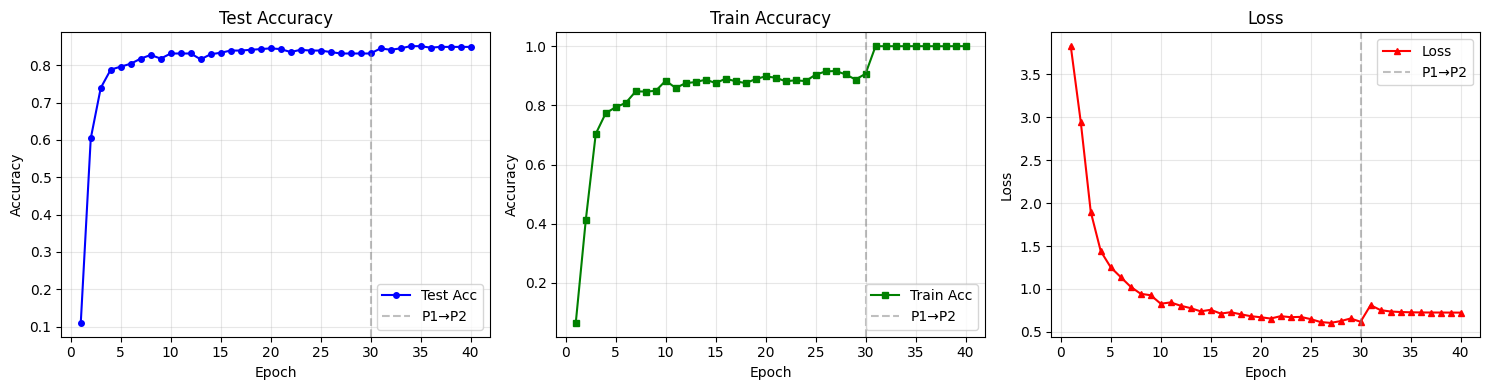


TRAINING SUMMARY
 epoch  phase     loss  train_acc  test_acc
     1      1 3.828662   0.064904  0.109804
     2      1 2.945938   0.411378  0.603922
     3      1 1.898581   0.703526  0.739216
     4      1 1.440556   0.773558  0.788235
     5      1 1.252355   0.793750  0.796078
     6      1 1.138325   0.808013  0.803922
     7      1 1.025130   0.847115  0.817647
     8      1 0.943858   0.846474  0.827451
     9      1 0.927188   0.848878  0.817647
    10      1 0.828652   0.883173  0.831373
    11      1 0.843469   0.858654  0.831373
    12      1 0.804748   0.875000  0.831373
    13      1 0.776941   0.878526  0.815686
    14      1 0.739646   0.886699  0.829412
    15      1 0.757835   0.875160  0.833333
    16      1 0.713728   0.890064  0.839216
    17      1 0.729120   0.881250  0.839216
    18      1 0.705760   0.875000  0.841176
    19      1 0.683466   0.888622  0.843137
    20      1 0.670868   0.897917  0.845098
    21      1 0.655712   0.893109  0.843137
    22      1 

In [9]:
df = pd.read_csv('training_history.csv')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Test Accuracy
axes[0].plot(df['epoch'], df['test_acc'], 'b-o', markersize=4, label='Test Acc')
axes[0].axvline(x=EPOCHS_P1, color='gray', linestyle='--', alpha=0.5, label='P1→P2')
axes[0].set_title('Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Train Accuracy
axes[1].plot(df['epoch'], df['train_acc'], 'g-s', markersize=4, label='Train Acc')
axes[1].axvline(x=EPOCHS_P1, color='gray', linestyle='--', alpha=0.5, label='P1→P2')
axes[1].set_title('Train Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Loss
axes[2].plot(df['epoch'], df['loss'], 'r-^', markersize=4, label='Loss')
axes[2].axvline(x=EPOCHS_P1, color='gray', linestyle='--', alpha=0.5, label='P1→P2')
axes[2].set_title('Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

# Print summary
print('\n' + '=' * 50)
print('TRAINING SUMMARY')
print('=' * 50)
print(df.to_string(index=False))

## 7. Per-Class Accuracy Analysis

Analyze model performance on each class after training.

In [ ]:
# Load best model and evaluate per-class
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best checkpoint
if os.path.exists('best_final.pt'):
    model.load_state_dict(torch.load('best_final.pt'))
    print('Loaded best_final.pt')
elif os.path.exists('best_p1.pt'):
    model.load_state_dict(torch.load('best_p1.pt'))
    print('Loaded best_p1.pt')
model.eval()

# Get predictions
all_preds = []
all_true = []

with torch.no_grad():
    for videos, video_ids in tqdm(test_loader, desc='Evaluating per-class'):
        videos = videos.to(DEVICE)
        preds = model(videos).logits.argmax(1).cpu().tolist()
        
        for vid, pred in zip(video_ids.tolist(), preds):
            true_label = gt_dict[str(vid)]
            all_true.append(true_label)
            all_preds.append(train_dataset.classes[pred])

# Overall accuracy
overall_acc = accuracy_score(all_true, all_preds)
print(f'\n{"="*60}')
print(f'OVERALL TEST ACCURACY: {overall_acc:.4f} ({overall_acc*100:.2f}%)')
print(f'{"="*60}')

In [ ]:
# Full classification report
print('\nPER-CLASS CLASSIFICATION REPORT:')
print('=' * 80)
report = classification_report(all_true, all_preds, target_names=train_dataset.classes, 
                                digits=4, zero_division=0)
print(report)

# Save report
with open('per_class_report.txt', 'w') as f:
    f.write(f'Overall Accuracy: {overall_acc:.4f}\n\n')
    f.write(report)
print('\n✓ Saved to per_class_report.txt')

In [ ]:
# Extract per-class accuracy and visualize
report_dict = classification_report(all_true, all_preds, target_names=train_dataset.classes, 
                                     output_dict=True, zero_division=0)

# Extract recall (accuracy) per class
class_accs = [(cls, report_dict[cls]['recall']) for cls in train_dataset.classes]
class_accs_sorted = sorted(class_accs, key=lambda x: x[1], reverse=True)

cls_names = [c[0] for c in class_accs_sorted]
cls_accs_vals = [c[1] * 100 for c in class_accs_sorted]

# Plot
plt.figure(figsize=(16, 6))
colors = ['darkgreen' if acc >= 90 else 'orange' if acc >= 70 else 'darkred' for acc in cls_accs_vals]
bars = plt.bar(range(len(cls_names)), cls_accs_vals, color=colors, alpha=0.7)
plt.axhline(y=overall_acc*100, color='blue', linestyle='--', linewidth=2, label=f'Overall ({overall_acc*100:.2f}%)')
plt.xlabel('Action Category', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Test Accuracy (Sorted by Performance)', fontsize=14, fontweight='bold')
plt.xticks(range(len(cls_names)), cls_names, rotation=90, ha='right', fontsize=8)
plt.ylim(0, 105)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Top and Bottom performing classes
print('\n' + '=' * 60)
print('🏆 TOP-5 BEST PERFORMING CLASSES:')
print('=' * 60)
for i in range(min(5, len(cls_names))):
    print(f'{i+1:2d}. {cls_names[i]:20s} {cls_accs_vals[i]:6.2f}%')

print('\n' + '=' * 60)
print('⚠️  TOP-5 WORST PERFORMING CLASSES:')
print('=' * 60)
for i in range(max(0, len(cls_names)-5), len(cls_names)):
    print(f'{len(cls_names)-i:2d}. {cls_names[i]:20s} {cls_accs_vals[i]:6.2f}%')

In [ ]:
# Top confusion pairs
cm = confusion_matrix(all_true, all_preds, labels=train_dataset.classes)

# Find top confusions (off-diagonal)
confusions = []
for i in range(len(train_dataset.classes)):
    for j in range(len(train_dataset.classes)):
        if i != j and cm[i, j] > 0:
            confusions.append((train_dataset.classes[i], train_dataset.classes[j], cm[i, j]))

confusions.sort(key=lambda x: x[2], reverse=True)

print('\n' + '=' * 70)
print('TOP-10 CONFUSION PAIRS (True → Predicted)')
print('=' * 70)
for i, (true_cls, pred_cls, count) in enumerate(confusions[:10]):
    print(f'{i+1:2d}. {true_cls:20s} → {pred_cls:20s} ({int(count):2d} errors)')

In [ ]:
# Final summary
print('\n' + '=' * 70)
print('FINAL TRAINING SUMMARY')
print('=' * 70)
print(f'Overall Test Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)')
print(f'Best performing class: {cls_names[0]} ({cls_accs_vals[0]:.2f}%)')
print(f'Worst performing class: {cls_names[-1]} ({cls_accs_vals[-1]:.2f}%)')
print(f'Classes with 100% accuracy: {sum(1 for acc in cls_accs_vals if acc >= 99.9)}')
print(f'Classes with <70% accuracy: {sum(1 for acc in cls_accs_vals if acc < 70)}')

# Save summary
summary = {
    'overall_accuracy': overall_acc,
    'best_class': cls_names[0],
    'best_acc': cls_accs_vals[0] / 100,
    'worst_class': cls_names[-1],
    'worst_acc': cls_accs_vals[-1] / 100,
}
pd.DataFrame([summary]).to_csv('analysis_summary.csv', index=False)
print('\n✓ Saved analysis_summary.csv')

## 8. Save Submission for Kaggle


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_final.pt'))
model.eval()
# Generate predictions
predictions = []
with torch.no_grad():
    for videos, video_ids in tqdm(test_loader, desc='Generating Submission'):
        videos = videos.to(DEVICE)
        preds = model(videos).logits.argmax(1).cpu().tolist()
        for vid, pred in zip(video_ids.tolist(), preds):
            predictions.append({'id': vid, 'class': train_dataset.classes[pred]})
# Sort by id and save
submission = pd.DataFrame(predictions).sort_values('id')
submission.to_csv('submission.csv', index=False)
print(f'Saved submission.csv ({len(submission)} rows)')
print(submission.head(10))

Generating Submission:   0%|          | 0/26 [00:00<?, ?it/s]

Saved submission.csv (510 rows)
   id         class
0   0  climb_stairs
1   1     flic_flac
2   2         climb
3   3         laugh
4   4          wave
5   5          turn
6   6        pullup
7   7         throw
8   8         catch
9   9          dive
